In [11]:
!pip install pyLDAvis
!pip install pyLDAvis.gensim
!pip install logging
!pip install wordcloud

!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm


/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim
/opt/conda/lib/python3.7/

In [1]:
#[to do] talk to team about removing this

# import nltk
# from nltk.sentiment import SentimentIntensityAnalyzer

# # Word lists and lexicons in nltk: https://www.nltk.org/howto/corpus.html#word-lists-and-lexicons
# nltk.download('vader_lexicon')
# sia = SentimentIntensityAnalyzer()
# sia.polarity_scores("This is a really great weather!")

# # Output:
# # [nltk_data] Downloading package vader_lexicon to /root/nltk_data...
# # [nltk_data]   Package vader_lexicon is already up-to-date!
# # {'compound': 0.6893, 'neg': 0.0, 'neu': 0.461, 'pos': 0.539}

In [13]:
import pandas as pd
import boto3

comprehend = boto3.client('comprehend', region_name='us-east-1')

df_weather = pd.read_csv ('final.csv')

df_weather.head()


,Unnamed: 0,Date,Count_Crashes,Count_Fatalities,text,Low,High,Precipitation,snow,snowdepth,windgust,windspeed,cloudcover,conditions,description
0,0,2016-01-01,0.0,0,,3.5,19.8,0.00,0.0,7.06,40.3,9.1,0.009,Clear,Clear conditions throughout the day.
1,1,2016-01-02,0.0,0,,4.6,23.5,0.00,0.0,7.02,33.3,7.7,0.623,Partially cloudy,Partly cloudy throughout the day.
2,2,2016-01-03,0.0,0,,19.1,26.2,0.00,0.0,6.73,34.4,5.8,0.834,Partially cloudy,Partly cloudy throughout the day.
3,3,2016-01-04,1.0,1,,18.2,30.0,0.00,0.0,6.48,28.9,7.9,0.823,Partially cloudy,Partly cloudy throughout the day.
4,4,2016-01-05,0.0,0,,27.3,38.4,0.01,0.0,6.03,0.0,14.1,0.930,"Snow, Overcast",Cloudy skies throughout the day with morning r...


In [4]:
#[To do] talk to team about removing this
#InputFieldName = "text"
#OutputFieldName_prefix = "Sentiment"

#iterate over each row calling comprehend for each and taking the result and saving it back to the datafrom
#for index, row in df_weather.iterrows():
    #this calls the comprehend service for each item in our data frame
    #res = comprehend.detect_sentiment(Text=df_weather.loc[index, InputFieldName], LanguageCode='en')
    
    #save sentiment scores to existing dataframe
    #df_weather.loc[index,f'{OutputFieldName_prefix}_Overall'] = res['Sentiment']
    #df_weather.loc[index,f'{OutputFieldName_prefix}_Positive'] = res["SentimentScore"]["Positive"]
    #df_weather.loc[index,f'{OutputFieldName_prefix}_Negative'] = res["SentimentScore"]["Negative"]
    #df_weather.loc[index,f'{OutputFieldName_prefix}_Neutral'] = res["SentimentScore"]["Neutral"]
    #df_weather.loc[index,f'{OutputFieldName_prefix}_Mixed'] = res["SentimentScore"]["Mixed"]

In [5]:
#df_weather['sentiment_overall'] = 0.00
#df_weather['sentiment_neg'] = 0.00
#df_weather['sentiment_neu'] = 0.00
#df_weather['sentiment_pos'] = 0.00

#for row in df_weather.itertuples():
    #sentiment = sia.polarity_scores(row[1])
    #df_weather.loc[row[0], 'sentiment_overall'] = sentiment['compound']
    #df_weather.loc[row[0], 'sentiment_neg'] = sentiment['neg']
    #df_weather.loc[row[0], 'sentiment_neu'] = sentiment['neu']
    #df_weather.loc[row[0], 'sentiment_pos'] = sentiment['pos']

#df_weather.head()

#df_weather.to_csv('Team_Project/weatherdataset.csv', index=False)
#df_weather.head(100)

In [29]:
import sys
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

#[to do] discuss the stop words
#stop_words.extend(['and', 'snow', 'mdt', 'salt', 'impact', 'valley', 'pm', 'effect', 'mph', 'lake', 'area', 'wasatch', 'advisory', 'front', 'wind', 'morning', 'condition', 'winter', 'mountain', 'weather','evening', 'expect', 'high', 'inch', 'travel', 'remain', 'tooele'])
stop_words.extend (['and', 'salt', 'lake', 'area', 'mdt', 'effect', 'impact', 'snow', 'valley', 'inch', 'weather', 'condition', 'advisory'])

# stop words advisories.csv - 4 topics : 'and', 'snow', 'mdt', 'salt', 'impact', 'valley', 'pm', 'effect', 'mph', 'lake', 'area', 'wasatch', 'advisory', 'front', 'wind', 'morning', 'condition', 'winter', 'mountain', 'weather','evening', 'expect', 'high', 'inch', 'travel', 'remain', 'tooele'
# stop words weather data 'day', 'cloudy', 'partly', 'afternoon', 'rain', 'clear', 'snow', 'sky', 'morning', 'later', 'condition', 'clearing', 'early', 'late', 'chance', 'become'
# stop words Dan data: temperature, pm
# stop: 'impact', 'snow', 'mph', 'salt', 'high', 'gust', 'mdt', 'weather', 'strong', 'wind', 'morning', 'possible', 'expect', 'valley', 'inch', 'lake', 'area', 'evening', 'heat', 'advisory', 'condition', 'accumulation', 'additional'
# Output:
# [nltk_data] Downloading package stopwords to /root/nltk_data...
# [nltk_data]   Package stopwords is already up-to-date!

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#[to do] Discuss removing - or changing.  This just remove retweets.  We've already cleaned out data in previous steps
# print(f'Total weather: {len(df_weather)}')
# df_originals = df_weather[~df_weather['text'].str.contains("RT @")]
# print(f'Original weather: {len(df_originals)}')

# # Output
# # Total weather: 1000
# # Original weather: 996

In [33]:
def sent_to_words(sentences):
    for sent in sentences:
        #[to do] are there other things we could add to this list?
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert each weather to a list of cleaned words and add to a master list
data = df_weather.text.values.tolist()

#print(data)

data_words = list(sent_to_words(data))
#for weather in data_words[:5]: # print the first :n weather word lists
#    print(weather)



In [34]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [35]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # remove stop words using list comprehension
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # add bigrams and trigrams using list comprehension
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]

    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])    # Load spacy, but we don't need the parser or NER (named entity extraction) modules

    # perform lemmatization and another round of stopword removal to catch any that were created by the lemmatization process
    for sent in texts:
      doc = nlp(" ".join(sent)) 
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

      # remove stopwords once more after lemmatization
      texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    

    return texts_out

data_ready = process_words(data_words)  # processed Text Data!
for weather in data_ready[:5]:
    print(weather)

[]
[]
[]
[]
[]


In [36]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

for row in id2word.iteritems():
  print(row)

(0, 'affected')
(1, 'also')
(2, 'caution')
(3, 'city')
(4, 'commute')
(5, 'create')
(6, 'difficult')
(7, 'driving')
(8, 'issue')
(9, 'less')
(10, 'mid')
(11, 'morning')
(12, 'motorist')
(13, 'poor')
(14, 'roadway')
(15, 'service')
(16, 'slick')
(17, 'timing')
(18, 'tooele')
(19, 'use')
(20, 'visibility')
(21, 'accordingly')
(22, 'accumulate')
(23, 'accumulation')
(24, 'affect')
(25, 'allow')
(26, 'amount')
(27, 'central')
(28, 'continue')
(29, 'desert')
(30, 'evening')
(31, 'extra')
(32, 'great')
(33, 'high')
(34, 'include')
(35, 'increase')
(36, 'locally')
(37, 'mountain')
(38, 'noon')
(39, 'northern')
(40, 'overnight')
(41, 'plan')
(42, 'possible')
(43, 'prepare')
(44, 'tapering')
(45, 'time')
(46, 'travel')
(47, 'western')
(48, 'winter')
(49, 'bulk')
(50, 'dawn')
(51, 'day')
(52, 'develop')
(53, 'difficulty')
(54, 'distance')
(55, 'early')
(56, 'follow')
(57, 'generally')
(58, 'hour')
(59, 'likely')
(60, 'midnight')
(61, 'pre')
(62, 'sanpete')
(63, 'sevi')
(64, 'snowfall')
(65, 'tap

In [37]:
# Create Corpus: Term Document Frequency - makes list of pairs - shows # of times a word shows up in each weather
corpus = [id2word.doc2bow(text) for text in data_ready]
corpus

[[],
 [],
 [],
 [],
 [],
 [],
 [(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 3),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 2)],
 [(3, 1),
  (4, 1),
  (7, 1),
  (8, 1),
  (11, 3),
  (15, 1),
  (17, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 2),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 2),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 2),
  (47, 1),
  (48, 2)],
 [],
 [],
 [],
 [],
 [],
 [],
 [(3, 1),
  (4, 2),
  (5, 1),
  (8, 1),
  (10, 1),
  (11, 4),
  (15, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (29, 1),
  (31, 2),
  (32, 1),
  (33, 1),
  (36, 1),
  (37, 1),
  (41, 1),
  (42, 1),
  (45, 2),
  (46, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),

In [38]:
# Change the number of topics in the LDA here
topics = 6

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # This is the corpus we created above
                                        id2word=id2word, # This is the dictionary we created above
                                        num_topics=topics,
                                        random_state=12345,
                                        chunksize=100,
                                        passes=5,
                                        per_word_topics=True)

ldatopics = lda_model.show_topics(formatted=False)
pprint(lda_model.print_topics())

[(0,
  '0.073*"night" + 0.073*"shower" + 0.034*"also" + 0.032*"indicate" + '
  '0.032*"thunderstorm" + 0.027*"forecast" + 0.024*"flood" + 0.020*"service" + '
  '0.019*"line_extende" + 0.018*"surface"'),
 (1,
  '0.111*"heat" + 0.042*"gusty" + 0.041*"hot" + 0.030*"work" + '
  '0.026*"participate" + 0.026*"normal" + 0.024*"excessive" + 0.023*"extend" + '
  '0.023*"event" + 0.023*"dangerously"'),
 (2,
  '0.091*"wind" + 0.065*"mph" + 0.039*"pm" + 0.030*"gust" + 0.023*"strong" + '
  '0.022*"include" + 0.020*"evening" + 0.019*"possible" + 0.019*"increase" + '
  '0.018*"midnight"'),
 (3,
  '0.050*"wasatch" + 0.043*"winter" + 0.040*"front" + 0.040*"pm" + '
  '0.040*"expect" + 0.037*"evening" + 0.037*"additional" + 0.035*"morning" + '
  '0.033*"accumulation" + 0.028*"detail"'),
 (4,
  '0.170*"road" + 0.164*"temperature" + 0.047*"low" + 0.037*"visibility" + '
  '0.036*"remainder" + 0.033*"location" + 0.026*"hard_freeze" + 0.022*"reduce" '
  '+ 0.018*"dense_fog" + 0.014*"kill"'),
 (5,
  '0.146*"po

In [39]:
df_fit = pd.DataFrame(columns=['topics', 'perplexity', 'coherence'])

for n in range(1,5):
    # Fit LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          id2word=id2word, 
                                          num_topics=n, 
                                          random_state=12345,
                                          chunksize=100, 
                                          passes=5,
                                          per_word_topics=True)

    # Generate fit metrics
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
    # Add metrics to df_fit
    df_fit.loc[str(n - 3)] = [n, round(lda_model.log_perplexity(corpus), 3), round(coherence_model_lda.get_coherence(), 3)]

df_fit
# Visualize results


,topics,perplexity,coherence
-2,1.0,-5.613,0.403
-1,2.0,-5.525,0.472
0,3.0,-5.453,0.584
1,4.0,-5.455,0.545


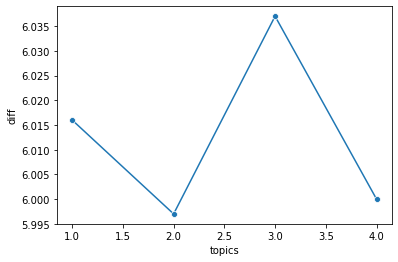

In [40]:
import seaborn as sns

df_fit['diff'] = abs(df_fit.coherence - df_fit.perplexity)
sns.lineplot(x='topics', y='diff', data=df_fit, ci=None, marker='o');

In [42]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                              id2word=id2word, 
                                              num_topics=topics, 
                                              random_state=12345,
                                              chunksize=100, 
                                              passes=5,
                                              per_word_topics=True)

df_topics = df_weather.copy()

num_topics = len(lda_model.get_topics()) # store the number of topics from the last model
for col in range(num_topics): # generate a new column for each topic
  df_topics[f'topic_{col + 1}'] = 0.0

# Store the topic score and dominant topic
for i, words in enumerate(data_ready):
  doc = lda_model[id2word.doc2bow(words)] # generate a corpus for this document set of words

  for j, score in enumerate(doc[0]): # for each document in the corpus
    # Get the topic score and store it in the appropriate column
    df_topics.iat[i, (len(df_topics.columns) - ((num_topics) - score[0]))] = score[1]

df_topics.head(10)
df_topics.to_csv('finalwithtopics.csv')

In [43]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

# Create the output DataFrame
df_representative_weather = pd.DataFrame(columns=df_topics.columns)

# Iterate through each topic
for n in range(1, num_topics + 1):
  # Copy the row from the original df with the highest topic score into the new df
  df_representative_weather.loc['topic_' + str(n)] = df_topics.loc[df_topics['topic_' + str(n)].idxmax()]

df_representative_weather

,Unnamed: 0,Date,Count_Crashes,Count_Fatalities,text,Low,High,Precipitation,snow,snowdepth,...,windspeed,cloudcover,conditions,description,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
topic_1,1003,2018-09-29,1.0,1,The National Weather Service in Salt Lake City has issued a * Flash Flood Watch for portions of...,67.1,87.0,0.0,0.0,0.0,...,23.7,0.678,Partially cloudy,Partly cloudy throughout the day.,0.680468,0.000000,0.000000,0.286956,0.000000,0.024059
topic_2,553,2017-07-06,0.0,0,...HEAT ADVISORY REMAINS IN EFFECT UNTIL 10 PM MDT THIS EVENING... * AFFECTED AREA...The Salt L...,72.9,100.5,0.0,0.0,0.0,...,13.6,0.321,Partially cloudy,Partly cloudy throughout the day.,0.039788,0.567037,0.000000,0.250535,0.000000,0.130873
topic_3,417,2017-02-20,0.0,0,...WIND ADVISORY IN EFFECT UNTIL 9 PM MST TUESDAY... The National Weather Service in Salt Lake ...,41.2,55.1,0.0,0.0,0.0,...,31.3,0.516,Partially cloudy,Partly cloudy throughout the day.,0.000000,0.000000,0.976156,0.000000,0.000000,0.000000
topic_4,725,2017-12-25,0.0,0,...WINTER WEATHER ADVISORY REMAINS IN EFFECT UNTIL NOON MST TODAY... * WHAT...Snow expected. Ad...,28.2,38.7,0.2,0.8,4.0,...,6.8,0.755,"Snow, Partially cloudy",Partly cloudy throughout the day with early morning snow.,0.000000,0.000000,0.000000,0.966621,0.000000,0.000000
topic_5,461,2017-04-05,0.0,0,...HARD FREEZE WARNING REMAINS IN EFFECT UNTIL 9 AM MDT THIS MORNING... * AFFECTED AREA...The v...,33.9,60.0,0.0,0.0,0.0,...,9.6,0.443,Partially cloudy,Partly cloudy throughout the day.,0.000000,0.000000,0.283400,0.113329,0.555068,0.038089
topic_6,1570,2020-04-17,1.0,1,...HARD FREEZE WARNING WILL EXPIRE AT 9 AM MDT THIS MORNING... Temperatures will continue to qu...,32.8,55.5,0.0,0.0,0.0,...,9.1,0.457,Partially cloudy,Partly cloudy throughout the day.,0.015152,0.015152,0.119132,0.015313,0.164811,0.670440


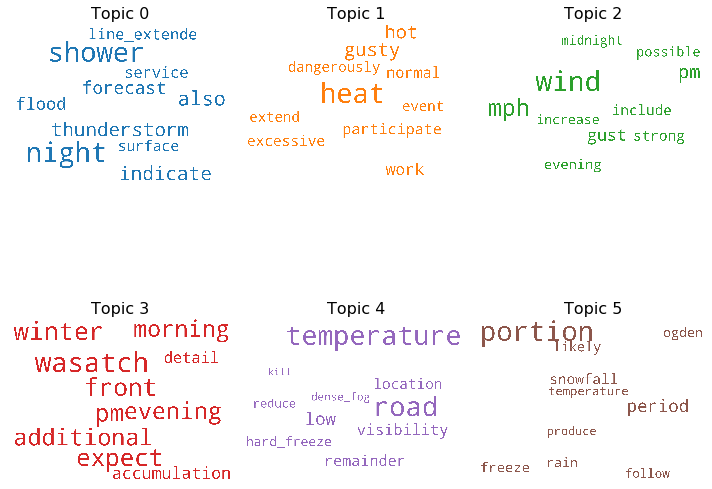

In [46]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2,3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    try:
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')
    except:
      continue


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

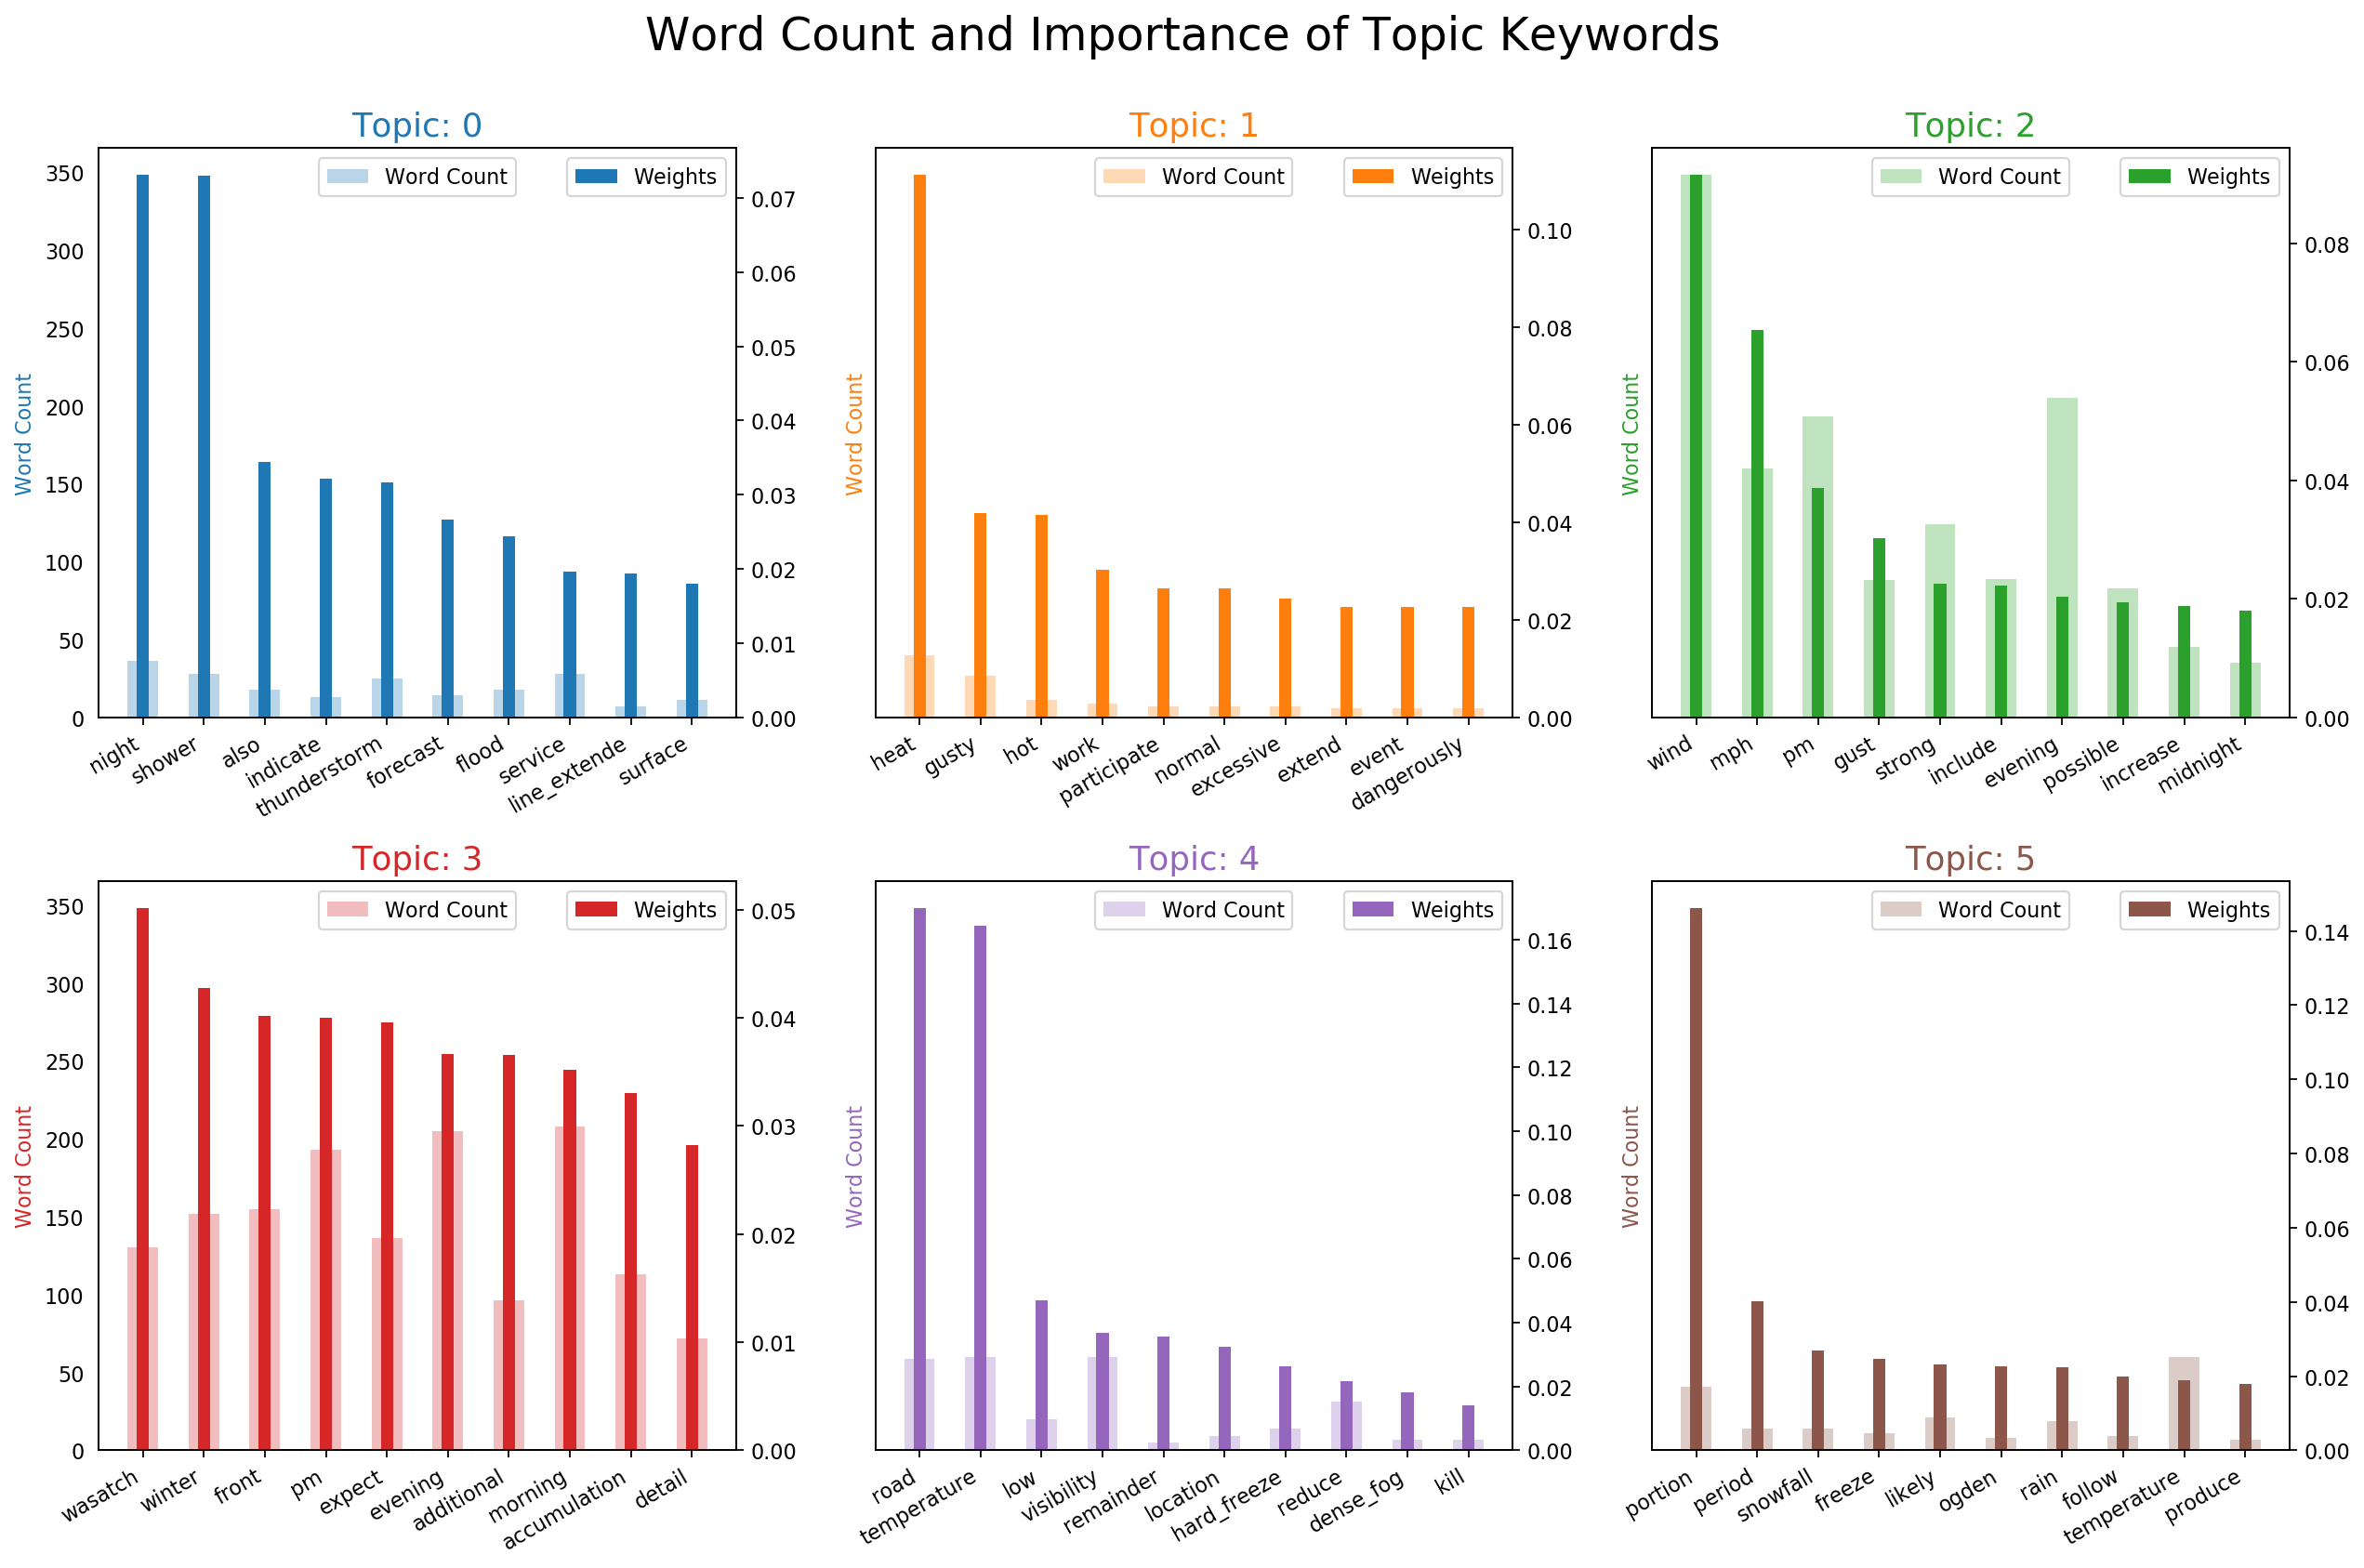

In [48]:
 # Bar chart of word counts for each topic
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper center'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [49]:
 # Get topic weights and dominant topics
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = topics
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 205 samples in 0.000s...
[t-SNE] Computed neighbors for 205 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 205 / 205
[t-SNE] Mean sigma: 0.120210
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.102264
[t-SNE] KL divergence after 1000 iterations: 0.219954


Loading BokehJS ...

In [50]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.318333  0.018716       1        1  38.878467
2      0.227113  0.026945       2        1  36.698862
5     -0.048358 -0.136100       3        1   7.070795
0     -0.168095 -0.033163       4        1   6.923749
1     -0.173653  0.274857       5        1   5.752959
4     -0.155340 -0.151255       6        1   4.675168, topic_info=            Term        Freq       Total Category  logprob  loglift
139         wind  282.000000  282.000000  Default  30.0000  30.0000
102      portion   87.000000   87.000000  Default  29.0000  29.0000
184         road   67.000000   67.000000  Default  28.0000  28.0000
297  temperature   76.000000   76.000000  Default  27.0000  27.0000
133          mph  202.000000  202.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
211        water    1.191973    2.361752   Topic6  -5.7976   2.3791
347         tree    4.617687   10.812403   Topic6  -4.4433   2.2121
338        fruit    0.682604    1.614037   Topic6  -6.3550   2.2023
66       tonight    3.541864   23.597121   Topic6  -4.7085   1.1664
275        guste    1.877066   10.997853   Topic6  -5.3435   1.2949

[269 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
22        1  0.935770    accumulate
23        1  0.991143  accumulation
494       4  0.903732        action
370       1  0.956785      activity
105       1  0.988883    additional
...     ...       ...           ...
47        2  0.975790       western
314       3  0.894192           wet
139       2  0.997028          wind
48        1  0.995104        winter
550       5  0.962653          work

[283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 1, 2, 5])